# **Data Preperation**

In [24]:
pip install catboost

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import torch
from transformers import CamembertTokenizer, CamembertModel
from tqdm import tqdm


##**Augmenting the dataset with swapping method**

In [26]:
import random

def random_swap(sentence):
    words = sentence.split()
    if len(words) < 2:  # Check if the sentence has fewer than two words
        return sentence
    idx1, idx2 = random.sample(range(len(words)), 2)  # Pick two distinct indices
    words[idx1], words[idx2] = words[idx2], words[idx1]  # Perform the swap
    return ' '.join(words)

Original Datasets

In [27]:
# Load your dataset
data_url = 'https://raw.githubusercontent.com/mariamnassar19/ML-project/main/training_data.csv'
data = pd.read_csv(data_url)
data

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
4795,4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,4797,"Et le premier samedi de chaque mois, venez ren...",A2
4798,4798,Les coûts liés à la journalisation n'étant pas...,C2


In [28]:
# Initialize the DataFrame for augmented data
augmented_rows = []

# Generate augmented data
for index, row in data.iterrows():
    new_sentence = random_swap(row['sentence'])
    new_id = max(data['id']) + index + 1  # Increment ID based on the maximum existing ID plus the index offset
    augmented_rows.append({'id': new_id, 'sentence': new_sentence, 'difficulty': row['difficulty']})

# Convert augmented rows to a DataFrame
augmented_data = pd.DataFrame(augmented_rows)

# Combine the original and augmented datasets
combined_data = pd.concat([data, augmented_data], ignore_index=True)

# Save the combined dataset (optional)
combined_data.to_csv('augmented_dataset6.csv', index=False)

##Display final dataset

In [29]:
train = pd.read_csv('https://raw.githubusercontent.com/shiqiy017/French/main/augmented_dataset6.csv')
test = pd.read_csv('https://raw.githubusercontent.com/shiqiy017/French/main/unlabelled_test_data.csv')
# Create X and y for the model training
X = train['sentence']
y = train['difficulty']

In [30]:
train = train.drop_duplicates()
train

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...,...
9595,9595,"C'est pourquoi, il décida de luxueux les habit...",B2
9596,9596,Il avait une de ces pâleurs splendides qui don...,C1
9597,9597,"Et le de samedi de chaque mois, venez rencontr...",A2
9598,9598,Les coûts liés à la journalisation n'étant pas...,C2


In [31]:
test

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...,...
1195,1195,C'est un phénomène qui trouve une accélération...
1196,1196,Je vais parler au serveur et voir si on peut d...
1197,1197,Il n'était pas comme tant de gens qui par pare...
1198,1198,Ils deviennent dangereux pour notre économie.


# **FlauBert Model**

In [20]:
pip install transformers datasets pandas scikit-learn

In [1]:
# Find the latest or a stable version that matches both libraries well.
!pip install transformers==4.20.0 accelerate==0.10.0 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [1]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 18.9 MB/s eta 0:00:00


In [3]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.5.0
    Uninstalling fsspec-2024.5.0:
      Successfully uninstalled fsspec-2024.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0, but you have fsspec 2024.3.1 which is incompatible.


##Compute_metrics
First we try with data splitting to see the accuracy and f1 score, we do two training loops

In [4]:
import pandas as pd
from datasets import Dataset, load_metric
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Load the dataset
data_url = 'https://raw.githubusercontent.com/mariamnassar19/ML-project/main/augmented_dataset6.csv'
data = pd.read_csv(data_url)

# Map difficulty to labels
difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
data['labels'] = data['difficulty'].map(difficulty_mapping)

# Splitting the data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.1)

# Convert to Hugging Face's Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

In [5]:
# Initialize tokenizer
tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize the model
model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=len(difficulty_mapping))


Downloading:   0%|          | 0.00/1.49M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/875k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Downloading:   0%|          | 0.00/528M [00:00<?, ?B/s]

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertForSequenceClassification: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

In [6]:
# Load metrics
accuracy_metric = load_metric('accuracy')
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')
f1_metric = load_metric('f1')

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall'],
        'f1': f1['f1']
    }

<ipython-input-6-2eb3520776fd>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric('accuracy')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [7]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results_flaubert',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train and evaluate the model first time
trainer.train()

# Save the model and tokenizer after the first round of training
model.save_pretrained('./flaubert_finetuned_first')
tokenizer.save_pretrained('./flaubert_finetuned_first')

# Optionally load the model and tokenizer if needed
model = FlaubertForSequenceClassification.from_pretrained('./flaubert_finetuned_first')
tokenizer = FlaubertTokenizer.from_pretrained('./flaubert_finetuned_first')

# Update training arguments for continued training
continued_training_args = TrainingArguments(
    output_dir='./results_flaubert_continued',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,  # Additional epochs for continued training
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_continued',
    logging_steps=50
)

# Reinitialize the Trainer with the updated arguments
trainer = Trainer(
    model=model,
    args=continued_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Continue training
trainer.train()

# Save the model and tokenizer after continued training
model.save_pretrained('./flaubert_continued')
tokenizer.save_pretrained('./flaubert_continued')


The following columns in the training set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8640
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1350


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.296700,1.120021,0.531250,0.536152,0.531250,0.527430
2,1.033500,0.986033,0.591667,0.628759,0.591667,0.562422
3,0.662100,0.773136,0.690625,0.713470,0.690625,0.681611
4,0.298400,0.511551,0.835417,0.836983,0.835417,0.835094
5,0.131900,0.498049,0.854167,0.858624,0.854167,0.854768


The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 960
  Batch size = 32
Saving model checkpoint to ./results_flaubert/checkpoint-270
Configuration saved in ./results_flaubert/checkpoint-270/config.json
Model weights saved in ./results_flaubert/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num 

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.151800,0.570048,0.853125,0.856115,0.853125,0.850786
2,0.184000,0.701100,0.823958,0.833259,0.823958,0.826419
3,0.113500,0.687957,0.855208,0.863018,0.855208,0.854056
4,0.054200,0.736580,0.864583,0.867339,0.864583,0.864058
5,0.043900,0.536404,0.903125,0.903892,0.903125,0.903220


The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 960
  Batch size = 32
Saving model checkpoint to ./results_flaubert_continued/checkpoint-270
Configuration saved in ./results_flaubert_continued/checkpoint-270/config.json
Model weights saved in ./results_flaubert_continued/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** R

('./flaubert_continued/tokenizer_config.json',
 './flaubert_continued/special_tokens_map.json',
 './flaubert_continued/vocab.json',
 './flaubert_continued/merges.txt',
 './flaubert_continued/added_tokens.json')

## Confusion Matrix

Next let's see the confusion matrix

loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/539b03cc777c9a7ade2e61b349c1a2718ebc34b2fdc1be23661c4af4794d19c7.54f2160ec9b24036aa3659b29dd457b2706dadb6bb37452f66662e009c6f06cd
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/4b497a793ad900a992634fcfc9ff415350e04b1b860f01dab9334c5989f9eb81.5a23e82e9ed3454c1a87fe4caf3681d0254d11a16bddc4059bc146257abb989b
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/4bfcc62bbe7304f2c09f0b03cb66e87ed0d47da9bf069e5fff3bcf1bc848af91.ff82f

Map:   0%|          | 0/8640 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0b9ef58865bb61b2a44569c51b24b441c7b6b49ba63c659fc4ad5d61ffa011d6.c03a6cc0529664af7ebd7b4b385954d9cd0071c3d965d9377ab407e2eaa06918
Model config FlaubertConfig {
  "amp": 1,
  "architectures": [
    "FlaubertWithLMHeadModel"
  ],
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": 0,
  "bptt": 512,
  "causal": false,
  "clip_grad_norm": 5,
  "dropout": 0.1,
  "emb_dim": 768,
  "embed_init_std": 0.02209708691207961,
  "encoder_only": true,
  "end_n_top": 5,
  "eos_index": 1,
  "fp16": true,
  "gelu_activation": true,
  "group_by_size": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "id2lang": {
    "0": "fr"
  },
  "init_std": 0.02,
  "is_encoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
   

Epoch,Training Loss,Validation Loss
1,1.278800,1.080320
2,1.052000,0.925200
3,0.604600,0.704547
4,0.300300,0.484624
5,0.114000,0.435801


The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 960
  Batch size = 32
Saving model checkpoint to ./results_flaubert_first/checkpoint-270
Configuration saved in ./results_flaubert_first/checkpoint-270/config.json
Model weights saved in ./results_flaubert_first/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evalu

Epoch,Training Loss,Validation Loss
1,0.126600,0.490538
2,0.188500,0.612392
3,0.166400,0.594591
4,0.116500,0.595672
5,0.105700,0.450217
6,0.058600,0.519730
7,0.045800,0.664019
8,0.031500,0.530611
9,0.017500,0.598059
10,0.008500,0.550396


The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 960
  Batch size = 32
Saving model checkpoint to ./results_flaubert_second/checkpoint-270
Configuration saved in ./results_flaubert_second/checkpoint-270/config.json
Model weights saved in ./results_flaubert_second/checkpoint-270/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `FlaubertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence, difficulty, id. If __index_level_0__, sentence, difficulty, id are not expected by `FlaubertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Ev

<Figure size 1000x1000 with 0 Axes>

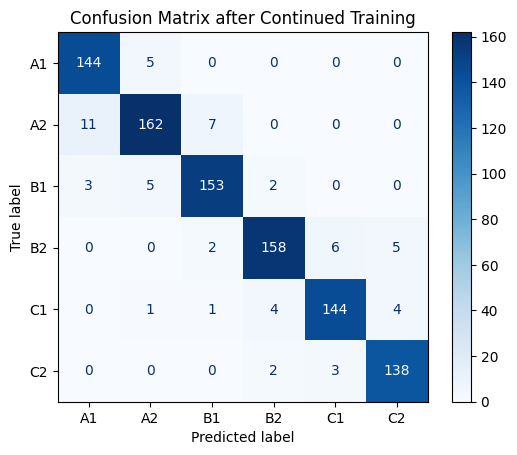

In [8]:
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
data_url = 'https://raw.githubusercontent.com/mariamnassar19/ML-project/main/augmented_dataset6.csv'
data = pd.read_csv(data_url)

# Map difficulty to labels
difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
data['labels'] = data['difficulty'].map(difficulty_mapping)

# Splitting the data into train and validation sets
train_data, val_data = train_test_split(data, test_size=0.1)

# Convert to Hugging Face's Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

# Initialize tokenizer
tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=128)

# Tokenize the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize the model
model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=len(difficulty_mapping))

# Define training arguments for the first training phase
first_training_args = TrainingArguments(
    output_dir='./results_flaubert_first',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_first',
    logging_steps=50
)

# Initialize the Trainer for the first training phase
first_trainer = Trainer(
    model=model,
    args=first_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# First training phase
first_trainer.train()

# Save the model and tokenizer after the first training phase
model.save_pretrained('./flaubert_finetuned_first')
tokenizer.save_pretrained('./flaubert_finetuned_first')

# Update training arguments for the second training phase
second_training_args = TrainingArguments(
    output_dir='./results_flaubert_second',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,  # Additional epochs for continued training
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_second',
    logging_steps=50
)

# Reinitialize the Trainer for the second training phase
second_trainer = Trainer(
    model=model,
    args=second_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Second training phase
second_trainer.train()

# Save the model and tokenizer after the second training phase
model.save_pretrained('./flaubert_continued')
tokenizer.save_pretrained('./flaubert_continued')

# Prediction and Confusion Matrix after the second training phase
predictions = second_trainer.predict(val_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

# Compute confusion matrix
cm = confusion_matrix(val_dataset['labels'], pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in difficulty_mapping])

# Plot confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix after Continued Training')
plt.show()


In [ ]:
from datasets import Dataset, load_from_disk

In [ ]:
# Load the dataset from disk or prepare it again
dataset = load_from_disk('/content/sample_data')

# Load the trained model and tokenizer
model = FlaubertForSequenceClassification.from_pretrained('./flaubert_finetuned_full')
tokenizer = FlaubertTokenizer.from_pretrained('./flaubert_finetuned_full')

# Define training arguments for the continuation
training_args = TrainingArguments(
    output_dir='./results_flaubert_continued',
    num_train_epochs=5,  # Additional epochs for continued training
    per_device_train_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_continued',
    logging_steps=50,
    save_strategy="epoch"
)

# Reinitialize the Trainer with the model and updated arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Continue training the model
trainer.train()

# Save the model and tokenizer after continued training
model.save_pretrained('./flaubert_continued')
tokenizer.save_pretrained('./flaubert_continued')

## Best model
We train on the whole dataset to maximize learning and get higher accuracy.

In [13]:
import pandas as pd
from datasets import Dataset
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, Trainer, TrainingArguments

# Load the dataset
data_url = 'https://raw.githubusercontent.com/mariamnassar19/ML-project/main/augmented_dataset6.csv'
data = pd.read_csv(data_url)

# Map difficulty to labels
difficulty_mapping = {'A1': 0, 'A2': 1, 'B1': 2, 'B2': 3, 'C1': 4, 'C2': 5}
data['labels'] = data['difficulty'].map(difficulty_mapping)

# Convert to Hugging Face's Dataset format
dataset = Dataset.from_pandas(data)

# Initialize tokenizer
tokenizer = FlaubertTokenizer.from_pretrained('flaubert/flaubert_base_cased')

def tokenize_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=128)

# Tokenize the dataset
dataset = dataset.map(tokenize_function, batched=True)
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Initialize the model
model = FlaubertForSequenceClassification.from_pretrained('flaubert/flaubert_base_cased', num_labels=len(difficulty_mapping))

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results_flaubert_full',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Train the model for the first time
trainer.train()

# Save the model and tokenizer after training is complete
model.save_pretrained('./flaubert_finetuned_full')
tokenizer.save_pretrained('./flaubert_finetuned_full')

# Assuming 'dataset' is your Hugging Face Dataset object after processing
dataset.save_to_disk('/content/sample_data')


loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/539b03cc777c9a7ade2e61b349c1a2718ebc34b2fdc1be23661c4af4794d19c7.54f2160ec9b24036aa3659b29dd457b2706dadb6bb37452f66662e009c6f06cd
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/4b497a793ad900a992634fcfc9ff415350e04b1b860f01dab9334c5989f9eb81.5a23e82e9ed3454c1a87fe4caf3681d0254d11a16bddc4059bc146257abb989b
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/4bfcc62bbe7304f2c09f0b03cb66e87ed0d47da9bf069e5fff3bcf1bc848af91.ff82f

Map:   0%|          | 0/9600 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/flaubert/flaubert_base_cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/0b9ef58865bb61b2a44569c51b24b441c7b6b49ba63c659fc4ad5d61ffa011d6.c03a6cc0529664af7ebd7b4b385954d9cd0071c3d965d9377ab407e2eaa06918
Model config FlaubertConfig {
  "amp": 1,
  "architectures": [
    "FlaubertWithLMHeadModel"
  ],
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": 0,
  "bptt": 512,
  "causal": false,
  "clip_grad_norm": 5,
  "dropout": 0.1,
  "emb_dim": 768,
  "embed_init_std": 0.02209708691207961,
  "encoder_only": true,
  "end_n_top": 5,
  "eos_index": 1,
  "fp16": true,
  "gelu_activation": true,
  "group_by_size": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "id2lang": {
    "0": "fr"
  },
  "init_std": 0.02,
  "is_encoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
   

Step,Training Loss
50,1.862700
100,1.735700
150,1.645400
200,1.480100
250,1.327400
300,1.244700
350,1.159200
400,1.080500
450,0.997900
500,1.015900


Saving model checkpoint to ./results_flaubert_full/checkpoint-300
Configuration saved in ./results_flaubert_full/checkpoint-300/config.json
Model weights saved in ./results_flaubert_full/checkpoint-300/pytorch_model.bin
Saving model checkpoint to ./results_flaubert_full/checkpoint-600
Configuration saved in ./results_flaubert_full/checkpoint-600/config.json
Model weights saved in ./results_flaubert_full/checkpoint-600/pytorch_model.bin
Saving model checkpoint to ./results_flaubert_full/checkpoint-900
Configuration saved in ./results_flaubert_full/checkpoint-900/config.json
Model weights saved in ./results_flaubert_full/checkpoint-900/pytorch_model.bin
Saving model checkpoint to ./results_flaubert_full/checkpoint-1200
Configuration saved in ./results_flaubert_full/checkpoint-1200/config.json
Model weights saved in ./results_flaubert_full/checkpoint-1200/pytorch_model.bin
Saving model checkpoint to ./results_flaubert_full/checkpoint-1500
Configuration saved in ./results_flaubert_full/che

Saving the dataset (0/1 shards):   0%|          | 0/9600 [00:00<?, ? examples/s]

We save the model, and try it on our unlabeled dataset

In [14]:
model_save_path = '/content/drive/MyDrive/flaubert_continued'

## Predict Test

In [15]:
import pandas as pd
from datasets import Dataset
from transformers import FlaubertTokenizer, FlaubertForSequenceClassification, Trainer

# Load the Flaubert tokenizer (ensure it's the same used during training)
tokenizer = FlaubertTokenizer.from_pretrained('./flaubert_finetuned_full')

# Define a function to tokenize the data (same as used in training)
def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=512)

# Load unlabeled data
unlabeled_data = pd.read_csv('https://raw.githubusercontent.com/mariamnassar19/ML-project/main/unlabelled_test_data.csv')

# Assuming 'sentence' is the column with text data. Adjust 'sentence' if your column key is different.
unlabeled_data['sentence'] = unlabeled_data['sentence'].astype(str)  # Ensure text data is string type

# Convert to a Hugging Face dataset and apply the tokenizer
unlabeled_dataset = Dataset.from_pandas(unlabeled_data)
unlabeled_dataset = unlabeled_dataset.map(tokenize_function, batched=True)
unlabeled_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

# Load the trained model
model = FlaubertForSequenceClassification.from_pretrained('/content/flaubert_continued')
trainer = Trainer(model=model)

# Predict with the trained model
predictions = trainer.predict(unlabeled_dataset).predictions
predicted_classes = predictions.argmax(axis=1)

# Assuming you have a difficulty mapping, map predicted classes to labels
difficulty_mapping = {0: 'A1', 1: 'A2', 2: 'B1', 3: 'B2', 4: 'C1', 5: 'C2'}  # Update this mapping as needed
predicted_difficulties = [difficulty_mapping[i] for i in predicted_classes]

# Prepare a DataFrame for output with IDs and predicted difficulties
submission_df = pd.DataFrame({
    'id': unlabeled_data['id'],  # Ensure 'id' exists in your CSV
    'difficulty': predicted_difficulties
})

# Save the predictions to a CSV file
submission_df.to_csv('unlabeled_predictions_final1.csv', index=False)

Didn't find file ./flaubert_finetuned_full/added_tokens.json. We won't load it.
loading file ./flaubert_finetuned_full/vocab.json
loading file ./flaubert_finetuned_full/merges.txt
loading file None
loading file ./flaubert_finetuned_full/special_tokens_map.json
loading file ./flaubert_finetuned_full/tokenizer_config.json


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

loading configuration file /content/flaubert_continued/config.json
Model config FlaubertConfig {
  "_name_or_path": "flaubert/flaubert_base_cased",
  "amp": 1,
  "architectures": [
    "FlaubertForSequenceClassification"
  ],
  "asm": false,
  "attention_dropout": 0.1,
  "bos_index": 0,
  "bos_token_id": 0,
  "bptt": 512,
  "causal": false,
  "clip_grad_norm": 5,
  "dropout": 0.1,
  "emb_dim": 768,
  "embed_init_std": 0.02209708691207961,
  "encoder_only": true,
  "end_n_top": 5,
  "eos_index": 1,
  "fp16": true,
  "gelu_activation": true,
  "group_by_size": true,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "id2lang": {
    "0": "fr"
  },
  "init_std": 0.02,
  "is_encoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "lang2id": {
    "fr": 0
  },
  "lang_id": 0,
  "langs": [
    "fr"
  ],
  "layer_n

And as we obtain our best results, we save the model to use it in our streamlit application.

In [ ]:
import os
print(os.listdir('/content/flaubert_finetuned_full'))

In [ ]:
!zip -r /content/flaubert_continued.zip /content/flaubert_continued
from google.colab import files
files.download('/content/flaubert_finetuned_full.zip')


# **CamemBERT Model**

## Feature Extraction and Difficulty Prediction with Camembert

This extracts mean-pooled features from input text data using the CamemBERT model and tokenizer, processing the text through the model on a specified device, and returning the concatenated feature array.

In [32]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming bert_feature is correctly defined somewhere above in your script
def bert_feature(data, **kwargs):
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertModel.from_pretrained('camembert-base').to(device)

    input_ids = [tokenizer.encode(text, add_special_tokens=True, **kwargs) for text in data]
    features = []
    with torch.no_grad():
        for input_id in tqdm(input_ids):
            input_tensor = torch.tensor(input_id).unsqueeze(0).to(device)
            input_embeds = model.embeddings(input_tensor)

            feature = np.mean(model(inputs_embeds=input_embeds)[0][:, :, :].cpu().numpy(), axis=1)


            features.append(feature)

    return np.concatenate(features, axis=0)

In [33]:
X = bert_feature(X)
# Display the outcome after the feature extraction
pd.DataFrame(X)

https://huggingface.co/camembert-base/resolve/main/sentencepiece.bpe.model not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpwysjd76r


Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/sentencepiece.bpe.model in cache at /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
creating metadata file for /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
https://huggingface.co/camembert-base/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyph70fha


Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/2fe780f7679200cac22b335648beff74d77883d9d4f2a18d8c853681f1f60f5f.024cc07195c0ba0b51d4f80061c6115996ff26233f3d04788855b23cdf13fbd5
creating metadata file for /root/.cache/huggingface/transformers/2fe780f7679200cac22b335648beff74d77883d9d4f2a18d8c853681f1f60f5f.024cc07195c0ba0b51d4f80061c6115996ff26233f3d04788855b23cdf13fbd5
loading file https://huggingface.co/camembert-base/resolve/main/sentencepiece.bpe.model from cache at /root/.cache/huggingface/transformers/dbcb433aefd8b1a136d029fe2205a5c58a6336f8d3ba20e6c010f4d962174f5f.160b145acd37d2b3fd7c3694afcf4c805c2da5fd4ed4c9e4a23985e3c52ee452
loading file https://huggingface.co/camembert-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/camembert-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/camembert-base/resolve/main/to

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
creating metadata file for /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
loading configuration file https://huggingface.co/camembert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f459e43c5ebb871abbf9209195563bff6a11547fd9532047739667c394833221.e23d229c54bcc6f67d337b8b2dd111b0e3dc01fa854bfecd3efdeb8c955749e6
Model config CamembertConfig {
  "_name_or_path": "camembert-base",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

storing https://huggingface.co/camembert-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
creating metadata file for /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
loading weights file https://huggingface.co/camembert-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/7e23f45751ad1fed420ca9f03bb37a279dc98a56c75bf25e671129237e2c893c.ee4d4253e08a7cf9697c0671fd8f022483dbf586691a7b32ead55493a34d72b2
Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you ar

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.044098,-0.009726,0.023424,0.099906,0.016738,-0.038137,0.022156,0.017088,0.007905,0.151338,...,0.043396,0.034236,0.009524,0.013186,0.056025,-0.095786,0.026427,-0.064338,0.047432,0.055505
1,0.028115,-0.064535,-0.054096,0.050308,-0.013887,-0.056776,-0.011159,0.012475,0.007124,0.190425,...,0.011579,-0.056370,0.055995,0.055943,0.088766,-0.008174,0.035211,-0.062624,0.053252,0.076783
2,0.017478,-0.068345,-0.022045,-0.056159,0.061777,-0.044523,0.050603,0.019951,0.001468,0.122604,...,0.011097,0.020317,-0.023543,-0.010805,0.045431,-0.045991,0.040901,-0.018517,0.042615,0.080906
3,-0.003268,-0.063029,-0.031644,0.016393,-0.023223,-0.012181,0.037862,0.100504,0.002922,0.149809,...,0.001416,-0.076411,-0.032009,0.077904,0.002996,-0.036797,0.114135,-0.012978,0.094237,0.081860
4,0.018052,0.012416,-0.076210,0.163193,-0.065282,-0.079802,-0.005715,0.029628,-0.011682,0.100215,...,0.046974,0.096272,-0.003839,-0.049703,0.119552,-0.035110,0.031109,-0.059324,0.002695,0.036682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,-0.044252,0.103004,-0.006917,0.062288,0.010110,0.029463,-0.027656,0.077498,0.036387,0.037218,...,0.043987,0.025340,-0.054688,-0.031710,0.031317,-0.090589,-0.011508,-0.055327,0.022999,-0.002141
9596,-0.042496,0.209497,-0.097413,0.049539,0.031634,-0.021377,0.005825,0.033372,0.053854,0.025469,...,0.087181,-0.007499,0.050244,-0.061791,0.002929,0.002360,0.012436,-0.007111,0.086625,-0.014872
9597,0.006506,0.012823,0.093976,0.087573,-0.011761,-0.066431,-0.000881,0.022568,0.018372,0.047036,...,-0.007426,-0.013906,0.029095,0.010458,0.020101,-0.051450,-0.062808,0.001387,-0.000534,-0.078865
9598,0.042044,-0.100966,-0.029397,0.109517,-0.016564,-0.036290,0.010916,0.059542,0.004116,0.142047,...,0.021835,0.048931,0.017873,0.011394,0.136551,-0.049599,0.056334,-0.094999,0.037084,0.064760


In [34]:
# Split the dataset into training and testing sets with 10% of the data reserved for testing, using random state 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [35]:
# Define the encoder
le = LabelEncoder()
# Fit the encoder
le.fit(y_train)

y_train = le.transform(y_train)
y_test = le.transform(y_test)
le.classes_

array(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], dtype=object)

##Compare Classification Models

In [37]:
# Initialize models
models = {
    'SVC': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'LightGBM': LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'MLP': MLPClassifier()
}

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='macro'),
        recall_score(y_test, y_pred, average='macro'),
        f1_score(y_test, y_pred, average='macro')
    ]

# DataFrame to hold comparison results
model_comparison = pd.DataFrame(index=['Accuracy', 'Precision', 'Recall', 'F1'])

# Fit models and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    model_comparison[name] = evaluate_model(model, X_test, y_test)

model_comparison

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 8640, number of used features: 768
[LightGBM] [Info] Start training from score -1.766390
[LightGBM] [Info] Start training from score -1.812813
[LightGBM] [Info] Start training from score -1.800828
[LightGBM] [Info] Start training from score -1.810687
[LightGBM] [Info] Start training from score -1.790372
[LightGBM] [Info] Start training from score -1.770460


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,SVC,Logistic Regression,Random Forest,Extra Trees,Decision Tree,LightGBM,CatBoost,MLP
Accuracy,0.584375,0.611458,0.746875,0.803125,0.480208,0.767708,0.729167,0.816667
Precision,0.581571,0.610771,0.758075,0.816391,0.485915,0.771089,0.731994,0.819788
Recall,0.590529,0.616047,0.751403,0.808997,0.483860,0.769641,0.733476,0.818994
F1,0.582995,0.610628,0.750005,0.806641,0.483641,0.769271,0.730173,0.818466
